In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_1 import *

Pytorch utils oh: pytorch_utils_oh_1.py
Pytorch: 0.2.0_4


In [2]:
MODEL_SAVE_PATH = 'category_3_normal_data_only_chars'

import pytorch_utils_oh_1; importlib.reload(pytorch_utils_oh_1); from pytorch_utils_oh_1 import *;

# Data loading

In [3]:
all_data = pickle.load(open("data/en_train_verbatim_1.pkl", "rb" ))

In [4]:
all_data_sentence_index = all_data.set_index('sentence_id')

In [5]:
all_data.sample(5)

,sentence_id,token_id,class,before,after
4602185,352557,1,PLAIN,a,a
7106565,539346,4,PUNCT,"""",""""
5860189,446733,5,PLAIN,Stryker's,Stryker's
4841757,370424,5,PUNCT,?,?
6177598,470406,5,PLAIN,find,find


In [6]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'VERBATIM' 'DECIMAL' 'MEASURE'
 'MONEY' 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE'
 'ADDRESS']
16


### More balanced sample

In [7]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
VERBATIM        78108
Name: class, dtype: int64

In [8]:
balanced_data_classes_select = list(all_data.groupby('class'))
def balanced_data_randomize(max_len=10000):
    global balanced_data
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
balanced_data_randomize()

In [9]:
balanced_data.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      10000
DATE          10000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       10000
MEASURE       10000
MONEY          6128
ORDINAL       10000
PLAIN         10000
PUNCT         10000
TELEPHONE      4024
TIME           1465
VERBATIM      10000
Name: class, dtype: int64

### Letters all

In [10]:
tmp = sorted(list(set(''.join(all_data['before']))))
characters_all = ['<EOS>', '<SOS>'] + sorted(list(set(tmp)))
characters_all_index = dict((c, i) for i, c in enumerate(characters_all))
print(''.join(characters_all))
print(len(characters_all))

<EOS><SOS> !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞☒
115


# Samples

In [11]:
def get_random_sample():
    sample_row = balanced_data.iloc[random.randint(1, len(balanced_data)-1)]
    sentence_id = sample_row['class']

    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = SAMPLE_WORD_TOKEN

    return sample_row['before'], sample_row['after'], sample_row['class'], befores
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(' '.join(s_sentence))
    print(string_to_tensor(s_bef, characters_all_index).shape)
tmp()

LETTERS : BD -> b d
Two <SAMPLE> / DVD compilation volumes were released : the first on March 6, 2013 and the second on April 3, 2013 .
torch.Size([1, 3, 115])


# Model

In [12]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, chars_input_size, chars_hidden_size, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.chars_layers = chars_layers
        self.chars_hidden_size = chars_hidden_size

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(chars_hidden_size, output_size)
        
    def forward(self, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_chars = self.init_hidden()
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = output_chars
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return (var2_1, var2_2)

In [13]:
model = CategorizeRNN(len(categories_all), chars_input_size=len(characters_all),
                      chars_hidden_size=128, chars_layers=2)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_3_normal_data_only_chars


CategorizeRNN (
  (rnn_chars): LSTM(115, 64, num_layers=2, batch_first=True, bidirectional=True)
  (lin_output): Linear (128 -> 16)
)

### Accuracy

In [40]:
def category_from_output(output, categories):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories[category_i], category_i

# print(category_from_output(output))
# category_from_output(tmp)
category_from_output(Variable(torch.rand(1, len(categories_all))), categories_all)

('DECIMAL', 6)

In [72]:
def test_model_single_eval(model):
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    string_t = string_to_tensor(s_bef, characters_all_index)
    
    string_t = Variable(string_t).cuda()
    
    output = model(string_t)
    guess = category_from_output(output, categories_all)
    return output, guess, (s_class, categories_index[s_class])

test_model_single_sample = test_model_single_eval
test_model_single_eval(model)

(Variable containing:
 
 Columns 0 to 7 
  -6.9491  -0.0015 -16.9563  -9.0860  -7.9421 -11.2581 -14.4997 -15.1040
 
 Columns 8 to 15 
 -12.4996 -12.1153 -11.3086 -11.1375  -9.9099 -12.5719 -11.9371 -12.5261
 [torch.cuda.FloatTensor of size 1x16 (GPU 0)], ('PUNCT', 1), ('PUNCT', 1))

In [55]:
def test_model_accuracy(model, test_n_sample=10000):
    model.eval()
    n_correct = 0
    
    for iteration in range(n_sample):        
        output, guess, correct = test_model_single_eval()
        
        if guess == correct:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))
    
    return(n_correct/n_sample)

In [47]:
%%time
test_model_accuracy(model)

Accuracy: 94.86% (    9486/   10000)
CPU times: user 14 s, sys: 112 ms, total: 14.1 s
Wall time: 14.1 s


0.9486

### Training

In [18]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()

    string_t = string_to_tensor(s_bef, characters_all_index)
    string_t = Variable(string_t).cuda()
    
    output = model(string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [19]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 10000 == 0 or model_training.iterations == 10:
            balanced_data_randomize()
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model)
            model.train()
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [20]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   2.768   |   2.80: ☒ -> PUNCT (✗ VERBATIM)
Saved model to data/models/category_3_normal_data_only_chars/10_(CategorizeRNN)
Accuracy: 8.76% (     876/   10000)
    18  36% (  0m 14s)   2.778   |   2.81: 4 -> PUNCT (✗ DIGIT)
    27  54% (  0m 15s)   2.775   |   2.75: .gov -> PUNCT (✗ ELECTRONIC)
    36  72% (  0m 15s)   2.766   |   2.68: 249 -> PUNCT (✗ CARDINAL)
    45  90% (  0m 15s)   2.760   |   2.74: 1.95 -> PUNCT (✗ DECIMAL)


In [21]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 2s)   2.715   |   2.62: .1 -> ORDINAL (✗ DECIMAL)


In [22]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (   0m 4s)   2.392   |   2.11: 3 km -> ORDINAL (✗ MEASURE)
  3000  20% (   0m 9s)   2.149   |   1.73: ☒ -> PUNCT (✗ VERBATIM)
  4000  30% (  0m 13s)   1.964   |   2.12: 0-7148-3924-8 -> MONEY (✗ TELEPHONE)
  5000  40% (  0m 18s)   1.729   |   1.26: November 4, 2014 -> ELECTRONIC (✗ DATE)
  6000  50% (  0m 23s)   1.623   |   1.39: 5 billion DKK -> MONEY (✓)
  7000  60% (  0m 27s)   1.430   |   0.94: .300 -> DECIMAL (✓)
  8000  70% (  0m 32s)   1.423   |   1.69: 9 -> VERBATIM (✗ CARDINAL)
  9000  80% (  0m 37s)   1.254   |   2.22: 2% -> CARDINAL (✗ MEASURE)
 10000  90% (  0m 41s)   1.066   |   2.48: 4,575 -> DECIMAL (✗ CARDINAL)
 11000 100% (  0m 46s)   0.903   |   0.88: 1903 -> DATE (✓)


In [23]:
train_iterations(n_iters=100000, print_every=10000)

 21000  10% (  0m 45s)   0.377   |   0.67: 2003 -> DATE (✓)
 31000  20% (  1m 31s)   0.267   |   2.27: 51 -> CARDINAL (✗ DIGIT)
 41000  30% (  2m 16s)   0.293   |   0.26: 36 -> CARDINAL (✓)
Saved model to data/models/category_3_normal_data_only_chars/50000_(CategorizeRNN)
Accuracy: 93.31% (    9331/   10000)
 51000  40% (  3m 14s)   0.177   |   0.00: ☒ -> VERBATIM (✓)
 61000  50% (  3m 58s)   0.174   |   0.00: , -> PUNCT (✓)
 71000  60% (  4m 42s)   0.205   |   0.00: 134th -> ORDINAL (✓)
 81000  70% (  5m 27s)   0.157   |   0.00: $500,000 -> MONEY (✓)
 91000  80% (  6m 11s)   0.203   |   0.17: 47 -> CARDINAL (✓)
Saved model to data/models/category_3_normal_data_only_chars/100000_(CategorizeRNN)
Accuracy: 94.55% (    9455/   10000)
101000  90% (  7m 11s)   0.195   |   0.00: 57 mm -> MEASURE (✓)
111000 100% (  7m 57s)   0.151   |   0.23: 50 -> CARDINAL (✓)


In [24]:
train_iterations(n_iters=100000, print_every=10000)

121000  10% (  0m 46s)   0.186   |   0.00: . -> PUNCT (✓)
131000  20% (  1m 32s)   0.175   |   0.12: 40 -> CARDINAL (✓)
141000  30% (  2m 20s)   0.168   |   0.00: " -> PUNCT (✓)
Saved model to data/models/category_3_normal_data_only_chars/150000_(CategorizeRNN)
Accuracy: 94.91% (    9491/   10000)
151000  40% (  3m 24s)   0.160   |   0.00: one -> PLAIN (✓)
161000  50% (  4m 17s)   0.170   |   0.03: SPORTV -> LETTERS (✓)
171000  60% (  5m 10s)   0.134   |   0.06: Smith -> PLAIN (✓)
181000  70% (   6m 3s)   0.150   |   0.62: 2 -> CARDINAL (✓)
191000  80% (  6m 56s)   0.137   |   3.48: 1985 -> DATE (✗ CARDINAL)
Saved model to data/models/category_3_normal_data_only_chars/200000_(CategorizeRNN)
Accuracy: 94.65% (    9465/   10000)
201000  90% (   8m 8s)   0.153   |   0.12: Hate -> PLAIN (✓)
211000 100% (   9m 4s)   0.211   |   0.01: - -> VERBATIM (✓)


# Results

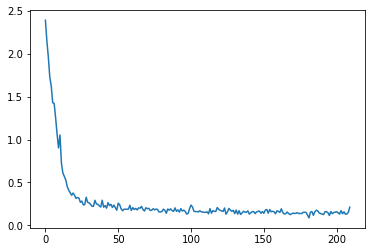

In [29]:
plt.figure()
plt.plot(model_training.losses)

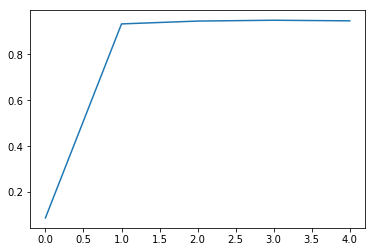

In [28]:
plt.figure()
plt.plot(model_training.accuracy)

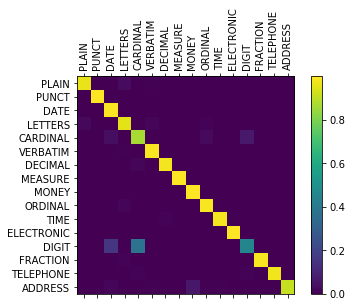

CPU times: user 1min 13s, sys: 768 ms, total: 1min 14s
Wall time: 1min 14s


In [67]:
%%time
plot_category_confusion_matrix(categories_all, test_model_single_eval, n_confusion=50000)

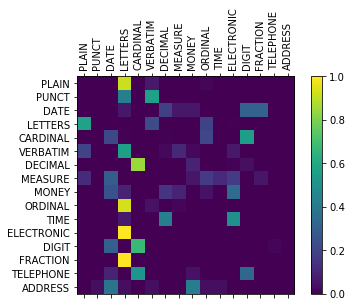

CPU times: user 1min 13s, sys: 724 ms, total: 1min 13s
Wall time: 1min 13s


In [73]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)